In [2]:
import pandas as pd
import os
import numpy as np

import matplotlib.pyplot as plt
from skimage import io

import torchvision.transforms as T
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, sampler

In [3]:
import matplotlib
%matplotlib inline

In [4]:
NUM_CLASS = 10
transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.43404748, 0.42429799, 0.40133824), 
                            (0.26775341, 0.26286543, 0.28041377))
            ])

In [5]:
class MiniplacesDataset(Dataset):
    
    def __init__(self, desc_file, root_dir, transform = T.ToTensor()):
        
        all_data = pd.read_csv(desc_file, delimiter=' ', header = None)
        self.desc_frame = all_data.loc[all_data.iloc[:, 1].isin(range(0, NUM_CLASS))]
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.desc_frame)
    
    def __getitem__(self, idx):
        img_names = os.path.join(self.root_dir, self.desc_frame.iloc[idx, 0])
        images = io.imread(img_names) / 255
        
        images = self.transform(images)
            
        return (images, self.desc_frame.iloc[idx,1])

In [6]:
train_data = MiniplacesDataset(desc_file='data/train.txt', root_dir='images/', transform = transform)
val_data = MiniplacesDataset(desc_file='data/val.txt', root_dir='images/', transform = transform)

In [7]:
loader_train = DataLoader(train_data, batch_size= 32, shuffle = True)
loader_val = DataLoader(val_data, batch_size= 32, shuffle = True)
# loader_test = DataLoader(test_data, batch_size=64)

In [8]:
device = torch.device('cpu')
dtype = torch.float32

In [9]:
def check_accuracy(loader, model, verbose = False):
    print('Checking accuracy on validation set')
    
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)

            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
            
        if verbose:
            print("Printing first 10 results in each batch")
            print("Groud truth: ", y[:20])
            print("Predicted: ", preds[:20])
            
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    

In [16]:
def train(model, optimizer, epochs=1, verbose=False, lr_decay = 0.9):
    """    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, lr_decay)
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)
            
            loss_history.append(loss)
            
    
            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
            
            if t % print_val == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy(loader_val, model, verbose)
                print()
            

In [17]:
def flatten(x):
    N = x.shape[0] 
    return x.view(N, -1)

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

In [18]:
# channel_1 = 16
# channel_2 = 8

# hidden_dim = 100

# learning_rate =  1e-3 # 2e-4 is too small
# reg = 1e-6

# print_loss = 50

# print_val = 100

# (size_0, size_1, size_2) = (3, 9, 81)

# loss_history = [] 

# model = nn.Sequential(
    
#     nn.AvgPool2d(2),
    
#     nn.Conv2d(3, 32, 3, padding=1, bias=True),
#     nn.ReLU(),
#     nn.BatchNorm2d(32),
#     nn.Dropout(),
#     nn.MaxPool2d(2),
    
#     nn.Conv2d(32, 16, 5, padding=2, bias=True),
#     nn.ReLU(),
#     nn.BatchNorm2d(16),
#     nn.MaxPool2d(2),
    
    
#     Flatten(),
#     nn.Linear(16 * 16 * 16, NUM_CLASS),
    
# )

# # optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
# # optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=reg)
# # optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# train(model, optimizer, epochs = 1)

In [23]:
channel_0, channel_1, hidden_dim = (32, 64, 300)
size_0, size_1 = (3,9)
p1, p2 = (0.3, 0.5)

print_val = 100



reg = 1e-3 # np.random.normal(1e-5,1e-7)
learning_rate = 1e-3 # 1e-3 and 5e-4 performs best



model = nn.Sequential(

nn.Conv2d(3, 3, 4, stride = 4, bias=True), # Downsampling
nn.BatchNorm2d(3),
nn.ReLU(),
nn.Dropout2d(p=p1),

nn.Conv2d(3, channel_0, size_0, padding = (size_0 - 1) // 2, bias=True),
nn.BatchNorm2d(channel_0),
nn.ReLU(),
nn.Dropout2d(p=p1),
nn.MaxPool2d(2),

nn.Conv2d(channel_0, channel_1, size_1, padding=(size_1 - 1) // 2, bias=True),
nn.BatchNorm2d(channel_1),
nn.ReLU(),
nn.Dropout2d(p=p1),
nn.MaxPool2d(2),

Flatten(),

nn.Linear(channel_1 * 8 * 8, hidden_dim),
nn.BatchNorm1d(hidden_dim),
nn.ReLU(),
nn.Dropout(p2),

nn.Linear(hidden_dim, NUM_CLASS)
)

# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=reg)
# optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_history = []

train(model, optimizer, epochs = 10, lr_decay = 0.9)

Iteration 0, loss = 2.3897
Checking accuracy on validation set
Got 119 / 1000 correct (11.90)

Iteration 100, loss = 2.0391
Checking accuracy on validation set
Got 268 / 1000 correct (26.80)

Iteration 200, loss = 2.4032
Checking accuracy on validation set
Got 312 / 1000 correct (31.20)

Iteration 300, loss = 2.1511
Checking accuracy on validation set
Got 341 / 1000 correct (34.10)

Iteration 0, loss = 1.8867
Checking accuracy on validation set
Got 336 / 1000 correct (33.60)

Iteration 100, loss = 2.1798
Checking accuracy on validation set
Got 368 / 1000 correct (36.80)

Iteration 200, loss = 2.0173
Checking accuracy on validation set
Got 353 / 1000 correct (35.30)

Iteration 300, loss = 1.9002
Checking accuracy on validation set
Got 331 / 1000 correct (33.10)

Iteration 0, loss = 1.9410
Checking accuracy on validation set
Got 365 / 1000 correct (36.50)

Iteration 100, loss = 1.9564
Checking accuracy on validation set
Got 354 / 1000 correct (35.40)

Iteration 200, loss = 1.7017
Checkin

RuntimeError: $ Torch: not enough memory: you tried to allocate 0GB. Buy new RAM! at /opt/conda/conda-bld/pytorch_1535491974311/work/aten/src/TH/THGeneral.cpp:204

In [11]:
reg = 1e-6 # np.random.normal(1e-5,1e-7)
learning_rate = 1e-3 # np.random.normal(1e-3,1e-5)
channel_0, channel_1, channel_2,channel_3, hidden_dim = (16,32,64,64,500)
size_0, size_1, size_2, size_3 = (3,5,7,9)
p1, p2 = (0.3, 0.5)

print_loss = 50
print_val = 100

model = nn.Sequential(
    
    nn.AvgPool2d(4),
    
    nn.Conv2d(3, channel_0, size_0, padding=(size_0 -1)//2, bias=True),
    nn.BatchNorm2d(channel_0),
    nn.ReLU(),
    nn.Dropout2d(p=p1),

    nn.Conv2d(channel_0, channel_1, size_1, padding=(size_1 -1)//2, bias=True),
    nn.BatchNorm2d(channel_1),
    nn.ReLU(),
    nn.Dropout2d(p=p1),
    nn.MaxPool2d(2),

    nn.Conv2d(channel_1, channel_2, size_2, padding=(size_2 -1)//2, bias=True),
    nn.BatchNorm2d(channel_2), # C in (N, C, H, W)
    nn.ReLU(),
    nn.Dropout2d(p=p1),

    nn.Conv2d(channel_2, channel_3, size_3, padding=(size_3 -1)//2, bias=True),
    nn.BatchNorm2d(channel_3),
    nn.ReLU(),
    nn.Dropout2d(p=p1),
    nn.MaxPool2d(2),

    Flatten(),

    nn.Linear(channel_3 * 8 * 8, hidden_dim),
    nn.BatchNorm1d(hidden_dim),
    nn.ReLU(),
    nn.Dropout(p2),

    nn.Linear(hidden_dim, NUM_CLASS)
)

# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=reg)
# optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_history = []
train(model, optimizer, epochs = 10)

Iteration 0, loss = 2.3658
Checking accuracy on validation set
Got 100 / 1000 correct (10.00)

Iteration 50, loss = 2.0089
Iteration 100, loss = 1.9752
Checking accuracy on validation set
Got 337 / 1000 correct (33.70)

Iteration 150, loss = 1.9646
Iteration 0, loss = 2.0727
Checking accuracy on validation set
Got 368 / 1000 correct (36.80)

Iteration 50, loss = 1.8265
Iteration 100, loss = 1.8963
Checking accuracy on validation set
Got 394 / 1000 correct (39.40)

Iteration 150, loss = 1.9293
Iteration 0, loss = 1.9597
Checking accuracy on validation set
Got 382 / 1000 correct (38.20)

Iteration 50, loss = 1.8306
Iteration 100, loss = 1.7742
Checking accuracy on validation set
Got 398 / 1000 correct (39.80)

Iteration 150, loss = 1.7587
Iteration 0, loss = 1.5588
Checking accuracy on validation set
Got 419 / 1000 correct (41.90)

Iteration 50, loss = 1.7101
Iteration 100, loss = 1.8986
Checking accuracy on validation set
Got 408 / 1000 correct (40.80)

Iteration 150, loss = 1.8539
Iter

KeyboardInterrupt: 

In [ ]:
# reg = np.random.normal(1e-5,1e-7)
# learning_rate = np.random.normal(1e-3,1e-5)
# channel_0, channel_1, channel_2,channel_3,hidden_dim = (16,32,64,64,500)
# size_0, size_1, size_2, size_3 = (3,5,7,9)
# p1, p2 = (0.3, 0.5)

# model = nn.Sequential(
    
#     nn.AvePool(4),
    
#     nn.Conv2d(3, channel_0, size_0, padding=(size_0 -1)//2, bias=True),
#     nn.BatchNorm2d(channel_0),
#     nn.ReLU(),
#     nn.Dropout2d(p=p1),

#     nn.Conv2d(channel_0, channel_1, size_1, padding=(size_1 -1)//2, bias=True),
#     nn.BatchNorm2d(channel_1),
#     nn.ReLU(),
#     nn.Dropout2d(p=p1),
#     nn.MaxPool2d(2),

#     nn.Conv2d(channel_1, channel_2, size_2, padding=(size_2 -1)//2, bias=True),
#     nn.BatchNorm2d(channel_2), # C in (N, C, H, W)
#     nn.ReLU(),
#     nn.Dropout2d(p=p1),

#     nn.Conv2d(channel_2, channel_3, size_3, padding=(size_3 -1)//2, bias=True),
#     nn.BatchNorm2d(channel_3),
#     nn.ReLU(),
#     nn.Dropout2d(p=p1),
#     nn.MaxPool2d(2),

#     Flatten(),

#     nn.Linear(channel_3 * 8 * 8, hidden_dim),
#     nn.BatchNorm1d(hidden_dim),
#     nn.ReLU(),
#     nn.Dropout(p2),

#     nn.Linear(hidden_dim, 10)
# )

#         optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=reg)
#         epochs = 10
        
#         model = model.to(device=device)  
        
#         for e in range(epochs):
#             scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.95)
            
#             for t, (x, y) in enumerate(loader_train):
#                 model.train()  
#                 x = x.to(device=device, dtype=dtype)  
#                 y = y.to(device=device, dtype=torch.long)

#                 scores = model(x)
#                 loss = F.cross_entropy(scores, y)

#                 optimizer.zero_grad()

#                 loss.backward()

#                 optimizer.step()

#                 if t % print_every == 0:
#                     print('Iteration %d, loss = %.4f' % (t, loss.item()))
#                     check_accuracy_part34(loader_val, model)
#                     val = return_accuracy(loader_val, model)
#                     if ( val > best_val):
#                         best_val = val
#                         best_model = model
#                     print()

#         val = return_accuracy(loader_val, model)

#         if ( val > best_val):
#             best_val = val
#             best_model = model
#             best_params = (dim_spec, learning_rate, reg, dropout_p)
            
#         print ('######################')
#         print ('Finished: ', (dim_spec, learning_rate, reg, dropout_p))
        
#         print ('######################')

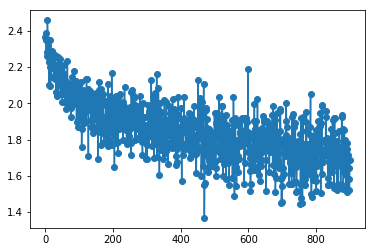

In [13]:
check_accuracy(loader_val, model)

Checking accuracy on validation set
Got 459 / 1000 correct (45.90)
